In [1]:
import numpy as np
import pandas as pd
import time
%matplotlib inline
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split,StratifiedShuffleSplit,cross_val_score,GridSearchCV
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier 
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from sklearn.metrics import r2_score,confusion_matrix,f1_score
from sklearn.linear_model import Ridge


# Reading Central & Satellite data

In [2]:
cent_data = pd.read_csv('/Users/saurabh/Google_Drive/Assembly_Bias/central/cenlgMh_mmcspenvani_1.txt', sep=",", header=None)
str1 = "/Users/saurabh/Google_Drive/Assembly_Bias/central/cenlgMh_mmcspenvani_"
for i in range(2,26):
    file2 = str1 + str(i) + '.txt'
    data2 = pd.read_csv(file2, sep=",", header=None)
    cent_data = cent_data.append(data2,ignore_index = True)
    print(i, end=' ')

2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 

In [3]:
sat_data = pd.read_csv('/Users/saurabh/Google_Drive/Assembly_Bias/satellite/new_satlgMh9col_1.txt', sep=",", header=None)
str1 = "/Users/saurabh/Google_Drive/Assembly_Bias/satellite/new_satlgMh9col_"
for i in range(2,26):
    file2 = str1 + str(i) + '.txt'
    data2 = pd.read_csv(file2, sep=",", header=None)
    sat_data = sat_data.append(data2,ignore_index = True)
    print(i, end=' ')

2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 

## Defining all columns of central and satellites

In [4]:
cent_data.columns = ['galaxyID','fofCentralId','subHaloID','phkey','con','mvir','vmax','a05','a08','vpeak',
'zvpeak','macc','smacc','mergnum','z_firstmerg','z_lastmerg','stellarMass','fofID',
'centralMvir','x','y','z','type','spinX','spinY','spinZ','g1_25','g2_5','g5','g10','alpha']

In [5]:
cent_data['total_spin'] = ((cent_data.spinX)**2 + 
(cent_data.spinY)**2 + (cent_data.spinZ)**2)**(1/2)
cent_data['total_spin'] = cent_data['total_spin']/cent_data['centralMvir'] #Spin/mass

In [6]:
sat_data.columns = ['galaxyID','fofCentralId','stellarMass','fofID','centralMvir','x','y','z','con']

# Predicting number of satellites in a halo

We are trying to predict the number of satellites above a threshold mass, $m_{\rm{above}} = 1.42\times 10^{10}~h^{-1}~{M_{\odot}}$,  a dark matter (DM) halo can have if we are given the halo properties. This is a regression (continuous values) problem. 

## Data Preparation

We begin with separating out all satellites that are above $m_{\rm{above}}$. We then identify the unique halos in this subset. The rest of the halos in the satellite data must have no satellites above mabove. In total, there are about 1.83 million unique halos which contain the satellites in the data. Training this huge dataset is computationally very expensive. We therefore must select a small sample of the halos and then train our machine learning model on it. Sampling the halos is not straightforward. As plotted below, there are 1.07 million halos (~ $58\%$) with mass $10^2 < m_{\textrm{vir}} < 10^3$ in Category 2. We therefore first bin $m_{\textrm{vir}}$ in bins of $ (0,10^0], (10^0,10^1], ..., (10^5,10^6] $ and stratify the sample based on these bins. 

In [7]:
def index_reset_drop(df):
    """
    Resets row indices, and drops index column from pandas 
    operation.
    df: pandas dataframe
    """
    df = df.reset_index()
    return df.drop(columns=['index'])

In [8]:
# Identifying unique halo IDs that contain atleast 1 satellite with
# m > 1.42

# sat_data_above is a pd df which contains data from sat_data 
# (entire satellite dataset) with m > 1.42.

sat_data_above = sat_data[sat_data['stellarMass'] > 1.42]
sat_data_above = index_reset_drop(sat_data_above)

# haloID_above contains the fofID (haloID) of sat_data_above
# sat_data_above["fofID"].value_counts() returns 2 columns: fofID and 
# #of satellites as a pandas.core.series.Series in the decreasing order
# of #of sats.
# .index returns the fofIDs column as a pandas.core.indexes.numeric.Int64Index
# .values returns the fofIDs column as a np array

haloID_above = sat_data_above["fofID"].value_counts().index.values

In [9]:
# Identifying halo IDs and corresponding halo properties of halos
# that do not contain any sat with m > 1.42

# sat_data_below is a pd df which contains data from sat_data 
# (entire satellite dataset) with m < 1.42.

sat_data_below = sat_data[~sat_data['fofID'].isin(haloID_above)]
sat_data_below = index_reset_drop(sat_data_below)

# halo_below is a pd df that contains halo properties of halos 
# containing no sats with m > 1.42 

haloID_below = sat_data_below['fofID'].unique()
halo_below = cent_data[cent_data['fofID'].isin(haloID_below)]
halo_below = index_reset_drop(halo_below)

In [10]:
# Identifying halo properties of halos with satellites m > 1.42

# halo_above is a pd df that contains halo properties of halos 
# containing atleast 1 sat with m > 1.42 

halo_above = cent_data[cent_data['fofID'].isin(haloID_above)]
halo_above = index_reset_drop(halo_above)

# Combining both halo classes

halo_full = halo_above.append(halo_below, ignore_index = True)

In [35]:
# Setting ground truth of halos

# sat_num.to_numpy() gives the values of the 2nd column (# of sats)
# in sat_num

sat_num = sat_data_above['fofID'].value_counts()
sat_num_np = sat_num.to_numpy()

# ground_truth_above contains 2 columns: haloIDs and # of sats

ground_truth_above = pd.DataFrame({'fofID': haloID_above, 
                    'Number of Sats': sat_num_np})

In [36]:
# ground_truth_above_sort contains sat numbers in ascending order
# of halo IDs

ground_truth_above_sort = ground_truth_above.sort_values(by = ['fofID'])
ground_truth_above_sort = index_reset_drop(ground_truth_above_sort)

# halo_above_sort contains halo properties in ascending order
# of halo IDs

halo_above_sort = halo_above.sort_values(by = ['fofID'])
halo_above_sort = index_reset_drop(halo_above_sort)

# Now add another column to halo properties that contains sat numbers

halo_above_sort['Number of Sats'] = ground_truth_above_sort['Number of Sats']
halo_below['Number of Sats'] = 0


In [37]:
halo_combined = halo_below.append(halo_above_sort)
halo_combined = index_reset_drop(halo_combined)

halo_combined_sort = halo_combined.sort_values(by = 'fofID')
halo_combined_sort = index_reset_drop(halo_combined_sort)

bins = np.zeros(8)
bins[1:] = 10**np.linspace(0,6,7)
labels = np.linspace(0,6,7)
halo_combined_sort['Sats Categories'] = pd.cut(halo_combined_sort['mvir'],bins = bins,
                                         labels=labels,right=True)

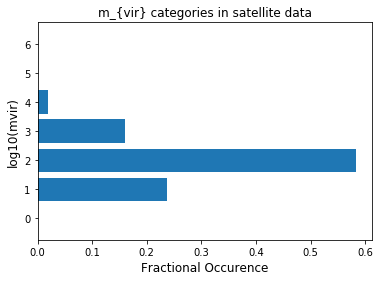

In [40]:
with PdfPages('mvir_dist.pdf') as pdf:
    col = halo_combined_sort['Sats Categories'].value_counts()
    plt.barh(col.index.values, col/sum(col))
    plt.ylabel('log10(mvir)', fontsize=12)
    plt.xlabel('Fractional Occurence', fontsize=12)
    plt.title(r'm_{vir} categories in satellite data', fontsize=12);
    pdf.savefig()

In [204]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.9, random_state=0)
df = halo_combined_sort
for train_index, test_index in split.split(df,df['Sats Categories']):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]
strat_train_set = index_reset_drop(strat_train_set)
strat_test_set = index_reset_drop(strat_test_set)

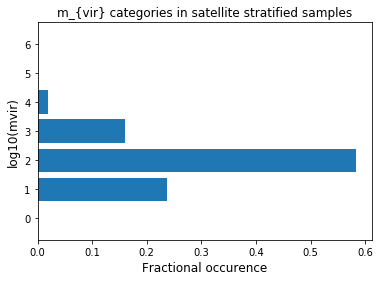

In [16]:
col = strat_train_set['Sats Categories'].value_counts()
plt.barh(col.index.values, col/sum(col))
plt.ylabel('log10(mvir)', fontsize=12)
plt.xlabel('Fractional occurence', fontsize=12)
plt.title(r'm_{vir} categories in satellite stratified samples', fontsize=12);

## Strategy

(1) Train a Random Forest (RF) Regression model on the halo data. The halo data contains halo properties, or _features_, and the number of satellites, or the _ground truth_.

(2) Plot feature importances, and then select the top 5-7 features.

(3) Plot the correlation matrix of the features, and then select the most important uncorrelated features.

(4) Run the RF regression model to predict the number of satellites for all halos in the data set.   


In [39]:
def bar_plot(rf, clmns, outfile):
    '''
    Bar plot in pdf.
    rf: RF model
    clmns: features
    outfile: output file name in pdf
    '''
    feature_imp = rf.feature_importances_
    features_arr = np.array(clmns)

    indices = np.argsort(feature_imp)

    with PdfPages(outfile) as pdf:
        fig = plt.figure(figsize=(12,12))
        ax = fig.add_subplot(111)
        plt.subplots_adjust(left = 0.2)
        ax.barh(range(len(indices)), feature_imp[indices])
        ax.set_yticks(range(len(indices)))
        ax.set_yticklabels([features_arr[i] for i in indices])
        pdf.savefig()

In [40]:
def corr_mat(correlation,outfile):
    with PdfPages(outfile) as pdf:
        f, ax_hm = plt.subplots(figsize=(7, 7))
        ax_hm = sns.heatmap(correlation, 
        xticklabels=correlation.columns,
        yticklabels=correlation.columns, annot = True, square = True)
        ax_hm.set_ylim(len(correlation), -0.01)
        pdf.savefig()    

Mean of RF Regression, max_features =  1.0 , Uncorrelated features =  0.918 , Std. Dev. =  0.014
Total r^2 score RF =  0.882
Test r^2 score RF =  0.876
time =   5 minutes
**********


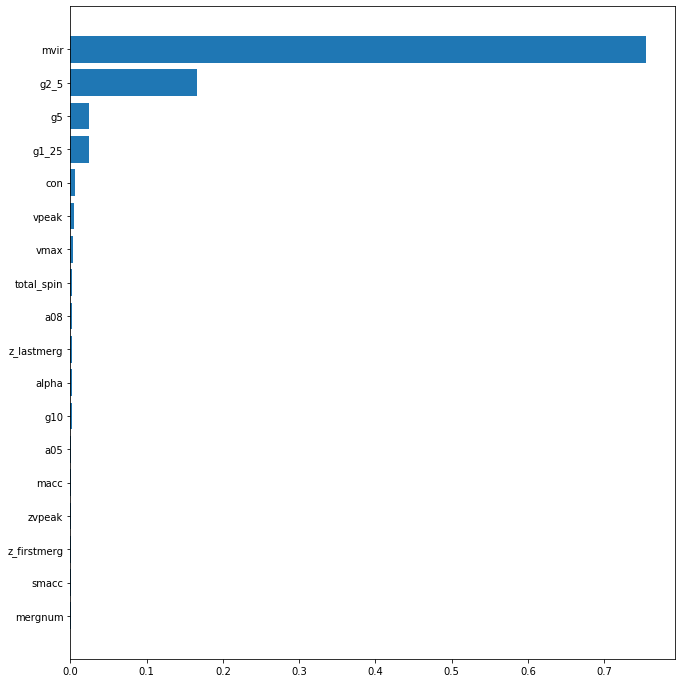

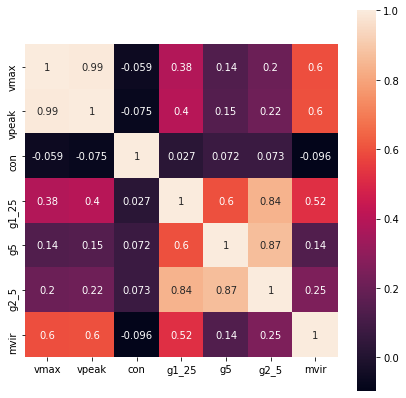

In [205]:
halo_features_all =  ['con','mvir','vmax','a05','a08','vpeak',
'zvpeak','macc','smacc','mergnum','z_firstmerg','z_lastmerg',
'total_spin','g1_25','g2_5','g5','g10','alpha']

#grid = ['log2', 1.0]
#feature_uncorr_reg = [['mvir','vmax','g1_25','g2_5','macc'],
#                      ['mvir','con','g2_5','g1_25']]
grid = [1.0]
feature_uncorr_reg = [['con','g2_5','mvir']]
halo_sample_shuffle = strat_train_set.copy()
y = halo_sample_shuffle['Number of Sats'].to_numpy()

for i in range(len(grid)):
    start = time.time()
    #X = pd.get_dummies(halo_sample_shuffle[halo_features_all])
    X = (halo_sample_shuffle[halo_features_all])
    X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 0)
    rfreg = RandomForestRegressor(n_estimators = 100, 
                max_depth = 20.0,min_samples_leaf = 5,
                n_jobs = -1,oob_score = False,random_state = 0,
                max_features=grid[i])
    rfreg.fit(X_train, y_train);
    outfile = 'feature_full_sat_' + str(grid[i]) + '.pdf'
    bar_plot(rfreg,X_train.columns,outfile)

    feature_imp = rfreg.feature_importances_
    features_arr = np.array(X_train.columns)

    indices = np.argsort(feature_imp)

    feature_pos = np.hstack((indices[-7:-1],indices[-1]))
    halo_features_top = features_arr[feature_pos]

    #X = pd.get_dummies(halo_sample_shuffle[halo_features_top])
    X = (halo_sample_shuffle[halo_features_top])
    outfile = 'heatmap_sat_' + str(grid[i]) + '.pdf'
    corr_mat(X.corr(),outfile)
       
    #X = pd.get_dummies(halo_sample_shuffle[feature_uncorr_reg[i]])
    X = (halo_sample_shuffle[feature_uncorr_reg[i]])
    X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 0)

    rfreg.fit(X_train, y_train); 
    rfreg_uncorr_scores = cross_val_score(rfreg, X, y, scoring="r2", cv=5)
    print('Mean of RF Regression,', 'max_features = ', grid[i], 
          ', Uncorrelated features = ', '{:0.3f}'.format(np.mean(rfreg_uncorr_scores)),
          ', Std. Dev. = ', '{:0.3f}'.format(np.std(rfreg_uncorr_scores)))  
    
    X_total = halo_combined[feature_uncorr_reg[i]]
    pred_total = rfreg.predict(X_total)
    true_total = halo_combined['Number of Sats']
    print('Total r^2 score RF = ', '{:0.3f}'.format(r2_score(true_total,pred_total)))

    strat_test = strat_test_set[feature_uncorr_reg[i]]
    pred_test = rfreg.predict(strat_test)
    true_test = strat_test_set['Number of Sats']    
    print('Test r^2 score RF = ', '{:0.3f}'.format(r2_score(true_test,pred_test)))

    end = time.time()
    print('time = ','{:2.0f}'.format((end - start)/60.),'minutes')
    print('**********')

# Making a pd column that contains predictions

halo_combined['Sat predicted'] = pred_total

In [43]:
halo_combined['Sat predicted Rounded Off'] = np.rint(halo_combined['Sat predicted'])

### Test individual models here

In [150]:
df = halo_combined_sort[(halo_combined_sort['Sats Categories'] == 0.0) |
                       (halo_combined_sort['Sats Categories'] == 1.0) |
                       (halo_combined_sort['Sats Categories'] == 2.0)]
df = index_reset_drop(df)
halo_sample_shuffle = df.sample(frac = 0.1)
halo_sample_shuffle = index_reset_drop(halo_sample_shuffle)

y = halo_sample_shuffle['Number of Sats'].to_numpy()
X = pd.get_dummies(halo_sample_shuffle[halo_features_all])
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 0)

start = time.time()
rfclass = RandomForestClassifier(n_estimators = 200, 
                max_depth = 20.0,min_samples_leaf = 10,
                n_jobs = -1,oob_score = False,random_state = 0,
                max_features=1.0)
rfclass.fit(X_train, y_train)
#rfreg.fit(X_train, y_train);
end = time.time()
print('time = ',end - start,'seconds')

time =  120.99778485298157 seconds


In [121]:
start = time.time()
rfreg_uncorr_scores = cross_val_score(rfreg, X, y, scoring="r2", cv=5)
print(rfreg_uncorr_scores)
print('mean = ', np.mean(rfreg_uncorr_scores),
      'std dev = ',np.std(rfreg_uncorr_scores))
end = time.time()
print('time = ', (end - start)/60.,'minutes')

[0.03426402 0.03686947 0.01361619 0.01404624 0.0328047 ]
mean =  0.026320124433718582 std dev =  0.010280873553887925
time =  1.453918699423472 minutes


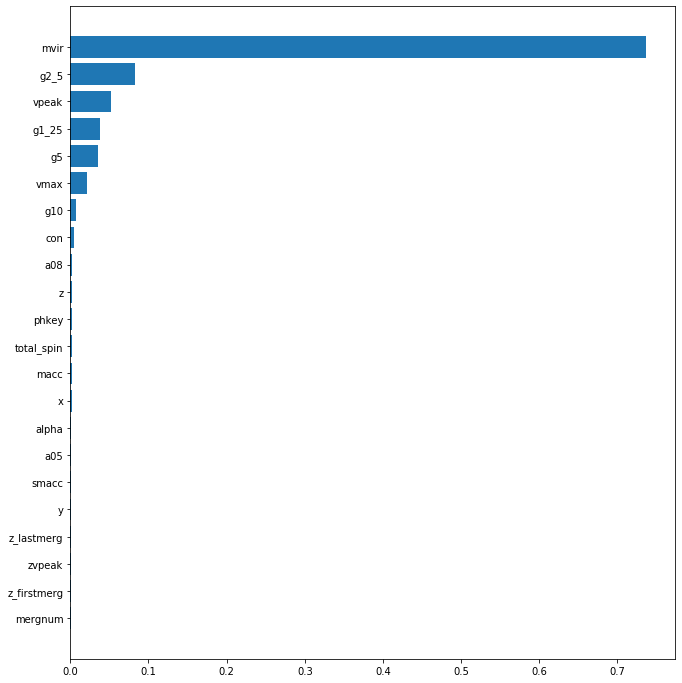

In [38]:
bar_plot(rfreg_10,X_train.columns,'feature_full_10.pdf')

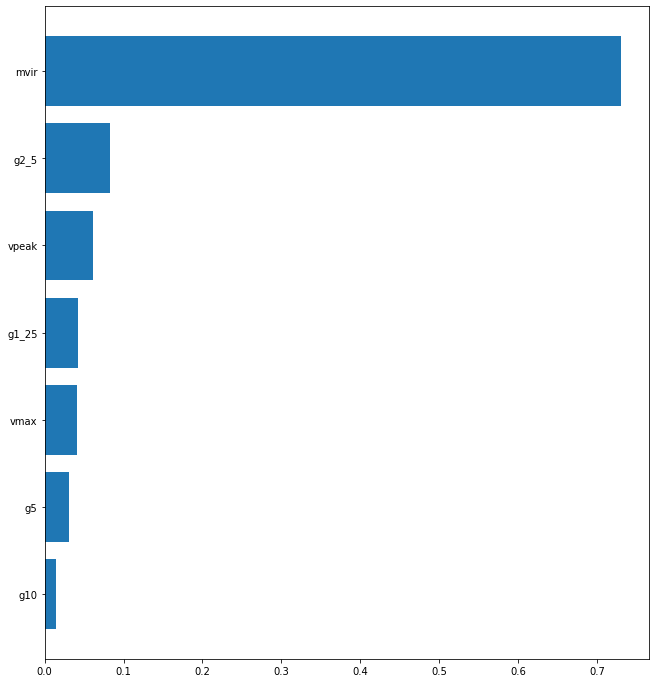

In [39]:
# Using top 7 features
feature_imp = rfreg_10.feature_importances_
features_arr = np.array(X_train.columns)

indices = np.argsort(feature_imp)

feature_pos = np.hstack((indices[-7:-1],indices[-1]))
halo_features_top = features_arr[feature_pos]

X = pd.get_dummies(halo_sample_shuffle[halo_features_top])

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 0)
rfreg_top = rfreg_10
rfreg_top.fit(X_train, y_train);
pred_rfreg_top = rfreg_top.predict(X_val)

#bar_plot(rfreg_top, X_train.columns, 'feature_imp_top.pdf')

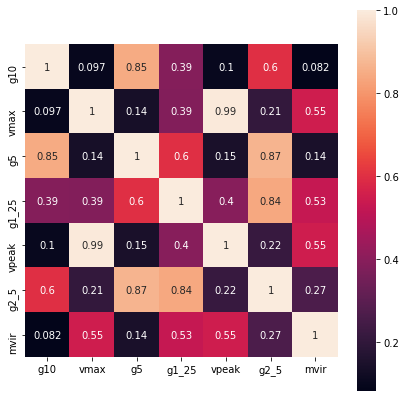

In [40]:
corr_mat(X.corr(),'heatmap_sat_10_top.pdf')

In [37]:
feature_uncorr_reg = ['mvir','vpeak','macc','g2_5','total_spin']
#feature_uncorr_reg = ['mvir','vpeak','g2_5','g1_25']
#feature_uncorr_reg = halo_features_top

In [88]:
y = halo_sample_shuffle['Number of Sats'].to_numpy()
X = pd.get_dummies(halo_sample_shuffle[feature_uncorr_reg])
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 0)

rfreg_uncorr = rfreg
rfreg_uncorr.fit(X_train, y_train);

In [89]:
rfreg_uncorr_scores = cross_val_score(rfreg_uncorr, X, y, scoring="neg_mean_squared_error", cv=5)
print(rfreg_uncorr_scores)
print(np.mean(rfreg_uncorr_scores),np.std(rfreg_uncorr_scores))

[-0.4355528  -1.8075054  -0.49192474 -0.57600157 -0.62211412]
-0.7866197259777719 0.5145333370986496


In [96]:
X_total = halo_combined[feature_uncorr_reg]
pred_total = rfreg_uncorr.predict(X_total)
true_total = halo_combined['Number of Sats']
print(r2_score(true_total,pred_total))
print(mse(true_total,pred_total))

0.9051502244242056
0.7077919256009177


In [55]:
strat_test = strat_test_set[feature_uncorr_reg]
pred_test = rfreg_uncorr.predict(strat_test)
true_test = strat_test_set['Number of Sats']
r2_score(true_test,pred_test)

0.8844781007791747

## Predicting Central galaxy occupation: Classification

Central data has 8.76 million rows! We'll first go through the entire data set, classify halos with central galaxy mass < 1.42 as 0, and 1 otherwise thereby creating the ground truth.

As we can guess, with centrals as well we must choose a stratified sample to train on from the entire data set. They key feature here in contrast to satellites is $v_{\textrm{max}}$. Category 2, as described below, with $10^2 < v_{\textrm{max}} < 10^3$ contains 6.85 million instances (~$78\%$). We must stratify our sample based on $v_{\text{max}}$ categories $ (0,10^0], (10^0,10^1], ..., (10^3,10^4] $   

In [65]:
def plot_conf_matrix(matrix,outfile):
    matrix_dnsty = np.zeros((2,2))
    matrix_dnsty[0,:] = matrix[0,:]/np.sum(matrix[0,:])
    matrix_dnsty[1,:] = matrix[1,:]/np.sum(matrix[1,:])
    plt.matshow(matrix_dnsty)
    plt.colorbar()
    plt.xlabel('Predicted')
    plt.ylabel('True')
    for i in range(2):
        for j in range(2):
            plt.text(i,j,str(np.around(matrix_dnsty[i,j],decimals=3)))
    with PdfPages(outfile) as pdf:
        pdf.savefig()

In [66]:
cent_data_cp = cent_data.copy()

cent_data_cp.loc[cent_data_cp['stellarMass'] < 1.42, 
                   'stellarMass'] = 0
cent_data_cp.loc[cent_data_cp['stellarMass'] > 1.42, 
                   'stellarMass'] = 1
cent_data_cp['stellarMass'] = cent_data_cp['stellarMass'].astype(int)

central_0 = cent_data_cp.loc[cent_data_cp['stellarMass'] == 0]
central_0 = index_reset_drop(central_0)

central_1 = cent_data_cp.loc[cent_data_cp['stellarMass'] == 1]
central_1 = index_reset_drop(central_1)


In [72]:
central_combined = central_0.append(central_1)
central_combined = index_reset_drop(central_combined)

central_combined_sort = central_combined.sort_values(by = 'fofID')
central_combined_sort = index_reset_drop(central_combined_sort)

#bins = np.zeros(6)
#bins[1:] = 10**np.linspace(0,4,5)
#labels = np.linspace(0,4,5)
#central_combined_sort['Cent Categories'] = pd.cut(central_combined_sort['vmax'],bins = bins,
#                                         labels=labels,right=True)
bins = np.zeros(8)
bins[1:] = 10**np.linspace(0,6,7)
labels = np.linspace(0,6,7)
central_combined_sort['Cent Categories'] = pd.cut(central_combined_sort['mvir'],bins = bins,
                                         labels=labels,right=True)

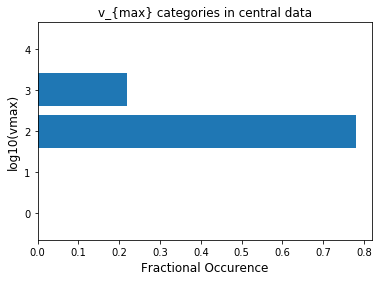

In [45]:
with PdfPages('vmax_dist.pdf') as pdf:
    col = central_combined_sort['Cent Categories'].value_counts()
    plt.barh(col.index.values, col/sum(col))
    plt.ylabel('log10(vmax)', fontsize=12)
    plt.xlabel('Fractional Occurence', fontsize=12)
    plt.title(r'v_{max} categories in central data', fontsize=12);
    pdf.savefig()

In [160]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.9885, random_state=0)
df = central_combined_sort
for train_index, test_index in split.split(df,df['Cent Categories']):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]
strat_train_set = index_reset_drop(strat_train_set)
strat_test_set = index_reset_drop(strat_test_set)

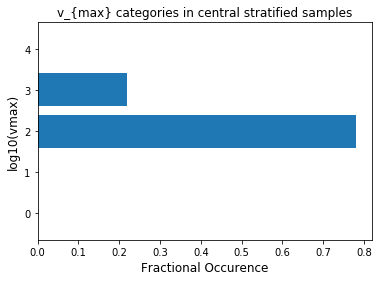

In [26]:
col = strat_train_set['Cent Categories'].value_counts()
plt.barh(col.index.values, col/sum(col))
plt.ylabel('log10(vmax)', fontsize=12)
plt.xlabel('Fractional Occurence', fontsize=12)
plt.title(r'v_{max} categories in central stratified samples', fontsize=12);

Mean of RF Classification, max_features =  1.0 , Uncorrelated features =  0.907 , Std. Dev. =  0.001
Test F1 score for RF =  0.907
Total F1 score for RF, max_features =  1.0 : 0.907
time =   5 minutes


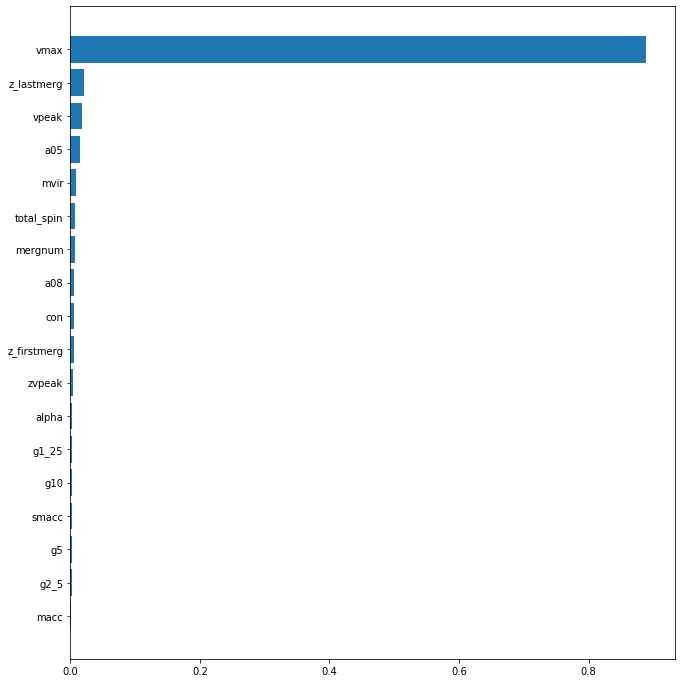

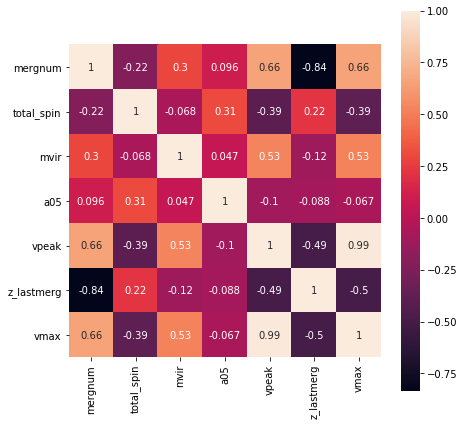

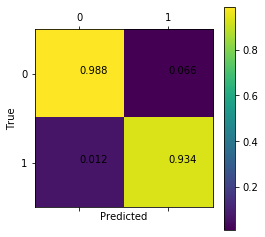

In [202]:
central_both_shuffle = strat_train_set.copy()

y = central_both_shuffle['stellarMass'].to_numpy()
#grid = ['log2',1.0]
#feature_uncorr_class = [['vmax','mvir','total_spin','z_firstmerg','macc'],
#                        ['vmax','z_lastmerg','total_spin','a05']]
grid = [1.0]
feature_uncorr_class = [['mvir','z_lastmerg','total_spin','a05']]

for i in range(len(grid)):
    start = time.time()
    X = pd.get_dummies(central_both_shuffle[halo_features_all])
    
    X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 0)
    rfclass = RandomForestClassifier(n_estimators = 200, 
                max_depth = 20.0,min_samples_leaf = 10,
                n_jobs = -1,oob_score = False,random_state = 0,
                max_features=grid[i])
    rfclass.fit(X_train, y_train);
    outfile = 'feature_full_cent_' + str(grid[i]) + '.pdf'
    bar_plot(rfclass,X_train.columns,outfile)
    
    feature_imp = rfclass.feature_importances_
    features_arr = np.array(X_train.columns)

    indices = np.argsort(feature_imp)

    feature_pos = np.hstack((indices[-7:-1],indices[-1]))
    halo_features_top = features_arr[feature_pos]

    X = pd.get_dummies(central_both_shuffle[halo_features_top])
    outfile = 'heatmap_cent_' + str(grid[i]) + '.pdf'
    corr_mat(X.corr(),outfile)

    X = pd.get_dummies(central_both_shuffle[feature_uncorr_class[i]])

    X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 0)
    rfclass.fit(X_train, y_train);

    pred_rf_uncorr = rfclass.predict(X_val)
    cm_cent_uncorr = confusion_matrix(y_val, pred_rf_uncorr)
    outfile = 'confusion_uncorr_' + str(grid[i]) + '.pdf'
    plot_conf_matrix(cm_cent_uncorr,outfile)
    rfclass_uncorr_scores = cross_val_score(rfclass, X, y, scoring="f1", cv=5)
    print('Mean of RF Classification,', 'max_features = ', grid[i], 
          ', Uncorrelated features = ','{:0.3f}'.format(np.mean(rfclass_uncorr_scores)),
          ', Std. Dev. = ', '{:0.3f}'.format(np.std(rfclass_uncorr_scores)))
    
    strat_test = strat_test_set[feature_uncorr_class[i]]
    pred_test = rfclass.predict(strat_test)
    true_test = strat_test_set['stellarMass']
    print('Test F1 score for RF = ', '{:0.3f}'.format(f1_score(true_test,pred_test)))

    X_total = cent_data_cp[feature_uncorr_class[i]]
    pred_total = rfclass.predict(X_total)
    true_total = cent_data_cp['stellarMass']
    print('Total F1 score for RF,', 'max_features = ', grid[i], ':', '{:0.3f}'.format(f1_score(true_total,pred_total)))

    end = time.time()
    print('time = ','{:2.0f}'.format((end - start)/60.),'minutes')
    
cent_data_cp['Cent predicted'] = pred_total    

In [27]:
central = pd.DataFrame(columns = ['fofID', 'Central Occupation (True)', 
                                   'Central Occupation (Predicted)'])
central['fofID'] = cent_data_cp['fofID']
central['Central Occupation (True)'] = cent_data_cp['stellarMass']
central['Central Occupation (Predicted)'] = cent_data_cp['Cent predicted']
central.to_csv('central.txt', header=None, index=None, sep=',')

### Test individual models here

In [91]:
# Shuffling
central_both_shuffle = central_both_sample.sample(frac=1).reset_index(drop=True)

y = central_both_shuffle['stellarMass'].to_numpy()
X = pd.get_dummies(central_both_shuffle[halo_features_all])

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 0)

rfclass_full = RandomForestClassifier(n_estimators = 300, 
                max_depth = 20.0,min_samples_leaf = 10,
                n_jobs = -1,oob_score = True,random_state = 0,
                max_features=1.0)

rfclass_full.fit(X_train, y_train);
pred_rfclass_cent = rfclass_full.predict(X_val)

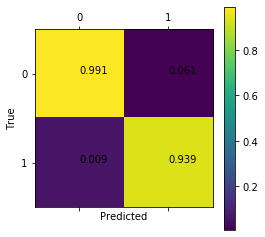

In [92]:
cm_cent = confusion_matrix(y_val, pred_rfclass_cent)
plot_conf_matrix(cm_cent,'confusion_matrix_full.pdf')

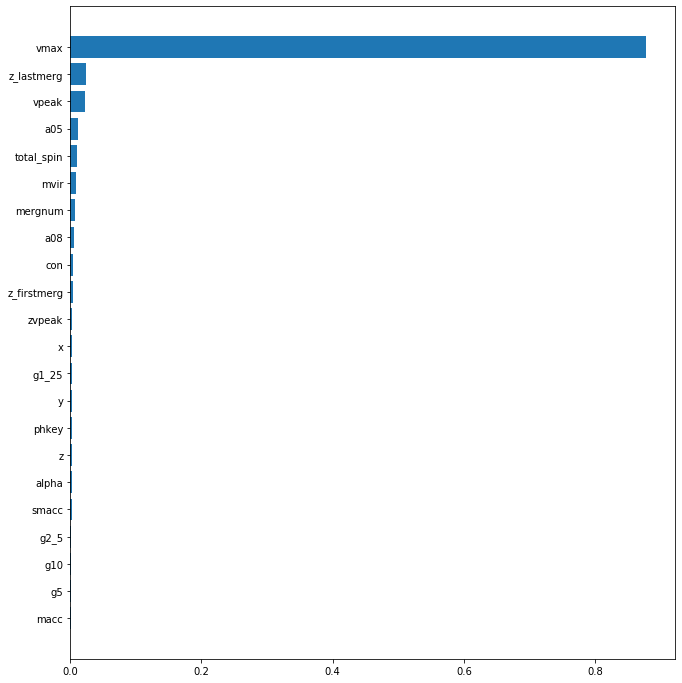

In [93]:
bar_plot(rfclass_full,X_train.columns,'feature_imp_full_cent.pdf')

In [94]:
tn, fp, fn, tp = confusion_matrix(y_val, pred_rfclass_cent).ravel()
recall = tp / (tp + fn)
prec = tp / (tp + fp)
accuracy = (tp + tn)/(tp + tn + fp + fn)
print(recall, prec, accuracy)
f1 = 2.0/((1.0/prec) + (1.0/recall))
print(f1)

0.9393364928909953 0.9029612756264237 0.98636
0.9207897793263647


In [40]:
rfclass_full_scores = cross_val_score(rfclass_full, X, y, scoring="f1", cv=5)
print(rfclass_full_scores)
print(np.mean(rfclass_full_scores),np.std(rfclass_full_scores))

[0.91983852 0.91939618 0.91405576 0.91149425 0.91316849]
0.9155906421457489 0.003392041648111548


In [95]:
# Using top 7 features
feature_imp = rfclass_full.feature_importances_
features_arr = np.array(X_train.columns)

indices = np.argsort(feature_imp)

feature_pos = np.hstack((indices[-7:-1],indices[-1]))
central_features_top = features_arr[feature_pos]

X = pd.get_dummies(central_both_shuffle[central_features_top])

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 0)
rfclass_top = RandomForestClassifier(n_estimators = 100, 
                max_depth = 20.0,min_samples_leaf = 5,
                n_jobs = -1,oob_score = True,random_state = 0,
                max_features='log2')

rfclass_top.fit(X_train, y_train);
#pred_rfclass_top = rfclass_top.predict(X_val)

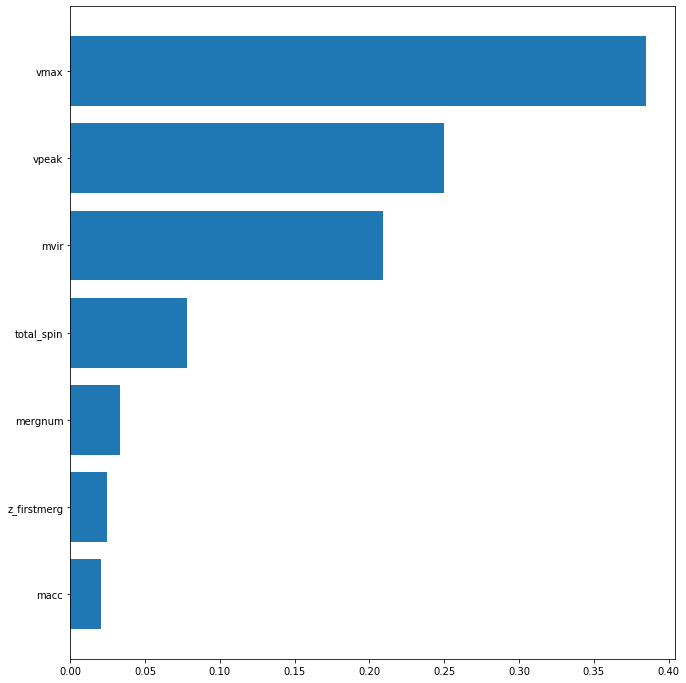

In [106]:
bar_plot(rfclass_top,X_train.columns,'feature_imp_top_cent.pdf')

In [107]:
rfclass_top_scores = cross_val_score(rfclass_top, X, y, scoring="f1", cv=5)
print(rfclass_top_scores)
print(np.mean(rfclass_top_scores),np.std(rfclass_top_scores))

[0.91217967 0.91580756 0.91370851 0.9027417  0.90694324]
0.9102761384726193 0.004772361502416144


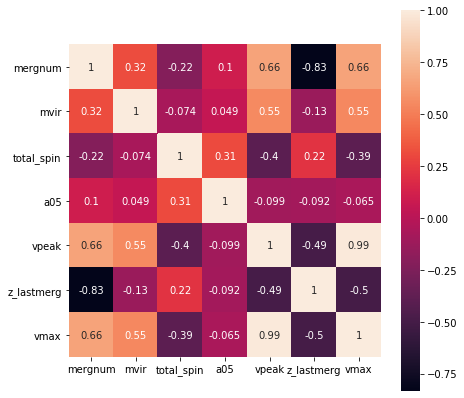

In [96]:
corr_mat(X.corr(),'heatmap_cent_top.pdf')

In [97]:
# Using only uncorrelated features
#feature_uncorr_class = ['vmax','mvir','z_firstmerg','macc','total_spin']
feature_uncorr_class = ['vmax','z_lastmerg','vpeak']

X = pd.get_dummies(central_both_shuffle[feature_uncorr_class])

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 0)
rfclass_uncorr = RandomForestClassifier(n_estimators = 200, 
                max_depth = 20.0,min_samples_leaf = 6,
                n_jobs = -1,oob_score = True,random_state = 0,
                max_features='log2')
rfclass_uncorr.fit(X_train, y_train);
#pred_rf_uncorr = rfclass_uncorr.predict(X_val)

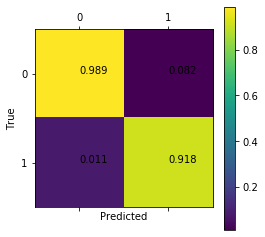

In [98]:
pred_rf_uncorr = rfclass_uncorr.predict(X_val)
cm_cent_uncorr = confusion_matrix(y_val, pred_rf_uncorr)
plot_conf_matrix(cm_cent_uncorr,'confusion_matrix_uncorr.pdf')

In [99]:
rfclass_uncorr_scores = cross_val_score(rfclass_uncorr, X, y, scoring="f1", cv=5)
print(rfclass_uncorr_scores)
print(np.mean(rfclass_uncorr_scores),np.std(rfclass_uncorr_scores))

[0.89787722 0.90138408 0.89333715 0.90820703 0.89939464]
0.900040025034804 0.0048688676069856196


# Centrals & Satellites Combined

In [48]:
halo_combined_sort = halo_combined.sort_values(by = 'fofID')
halo_combined_sort = index_reset_drop(halo_combined_sort)
cent_data_sat = cent_data_cp[cent_data_cp['fofID'].isin(halo_combined_sort.fofID)]

In [49]:
cent_data_sat_sort = cent_data_sat.sort_values(by = 'fofID')
cent_data_sat_sort = index_reset_drop(cent_data_sat_sort)

halo_combined_sort['central_0_or_1'] = cent_data_sat_sort['stellarMass']
halo_combined_sort['Cent predicted'] = cent_data_sat_sort['Cent predicted']
halo_combined_sort['Central plus Sat'] = halo_combined_sort['central_0_or_1'] + halo_combined_sort['Number of Sats']

bins = np.zeros(8)
bins[1:] = 10**np.linspace(0,6,7)
labels = np.linspace(0,6,7)

halo_combined_sort['Cent-Sats Categories'] = pd.cut(halo_combined_sort['mvir'],
                                        bins = bins, labels=labels,right=True)
halo_combined_shuffle = halo_combined_sort.sample(frac=1).reset_index(drop=True)

In [50]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.9, random_state=10)

df = halo_combined_shuffle
for train_index, test_index in split.split(df,df['Cent-Sats Categories']):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]
strat_train_set = index_reset_drop(strat_train_set)
strat_test_set = index_reset_drop(strat_test_set)

In [51]:
#grid = ['log2', 1.0]
#feature_uncorr_reg = [['mvir','vpeak','macc','g2_5','total_spin'],
#                      ['mvir','con','g2_5','g1_25']]
grid = [1.0]
feature_uncorr_reg = [['mvir','con','g2_5','g1_25']]
halo_sample_shuffle = strat_train_set.copy()
y = halo_sample_shuffle['Number of Sats'].to_numpy()

for i in range(len(grid)):
    start = time.time()
    X = pd.get_dummies(halo_sample_shuffle[halo_features_all])
    X1 = X.copy()
    X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 0)
    rfreg = RandomForestRegressor(n_estimators = 100, 
                max_depth = 20.0,min_samples_leaf = 5,
                n_jobs = -1,oob_score = False,random_state = 0,
                max_features=grid[i])
    rfreg.fit(X_train, y_train);
    #outfile = 'feature_full_cent_sat_' + str(grid[i]) + '.pdf'
    #bar_plot(rfreg,X_train.columns,outfile)

    feature_imp = rfreg.feature_importances_
    features_arr = np.array(X_train.columns)

    indices = np.argsort(feature_imp)

    feature_pos = np.hstack((indices[-7:-1],indices[-1]))
    halo_features_top = features_arr[feature_pos]

    X = pd.get_dummies(halo_sample_shuffle[halo_features_top])
    #outfile = 'heatmap_cent_sat_' + str(grid[i]) + '.pdf'
    #corr_mat(X.corr(),outfile)
       
    X = pd.get_dummies(halo_sample_shuffle[feature_uncorr_reg[i]])
    X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 0)

    rfreg.fit(X_train, y_train); 
    #rfreg_uncorr_scores = cross_val_score(rfreg, X, y, scoring="r2", cv=5)
    print('Mean of RF Regression,', 'max_features = ', grid[i], 
          ', Uncorrelated features = ', '{:0.3f}'.format(np.mean(rfreg_uncorr_scores)),
          ', Std. Dev. = ', '{:0.3f}'.format(np.std(rfreg_uncorr_scores)))  
    
    X_total = halo_combined_shuffle[feature_uncorr_reg[i]]
    pred_total = rfreg.predict(X_total)
    true_total = halo_combined_shuffle['Number of Sats']
    print('Total r^2 score RF = ', '{:0.3f}'.format(r2_score(true_total,pred_total)))

    strat_test = strat_test_set[feature_uncorr_reg[i]]
    pred_test = rfreg.predict(strat_test)
    true_test = strat_test_set['Number of Sats']
    print('Test r^2 score RF = ', '{:0.3f}'.format(r2_score(true_test,pred_test)))

    end = time.time()
    print('time = ','{:2.0f}'.format((end - start)/60.),'minutes')
    print('**********')
    
halo_combined_shuffle['Cent+Sat predicted'] = pred_total

Mean of RF Regression, max_features =  1.0 , Uncorrelated features =  0.922 , Std. Dev. =  0.014
Total r^2 score RF =  0.886
Test r^2 score RF =  0.879
time =   3 minutes
**********


In [52]:
halo_combined_shuffle['Cent+Sat predicted Rounded Off'] = np.rint(halo_combined_shuffle['Cent+Sat predicted'])

In [53]:
halo_combined_final = halo_combined_shuffle.copy()
df = halo_combined_final
cols = np.hstack((df.columns[-9:-1],df.columns[-1]))
df = df.drop(columns=cols,axis=1) 
df2 = halo_combined_shuffle
df['Number of Satellites (True)'] = df2['Number of Sats']
df['Number of Satellites (Predicted)'] = df2['Sat predicted Rounded Off']
df['Central Occupation (True)'] = df2['central_0_or_1']
df['Central Occupation (Predicted)'] = df2['Cent predicted']
df['Central and Satellites (True)'] = df2['Central plus Sat']
df['Central and Satellites Together (Predicted)'] = df2['Cent+Sat predicted Rounded Off']
df['Central and Satellites Separate (Predicted)'] = df2['Sat predicted Rounded Off'] + df2['Cent predicted']

halo_combined_final = df.copy()

/Users/saurabh/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  del sys.path[0]
/Users/saurabh/opt/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


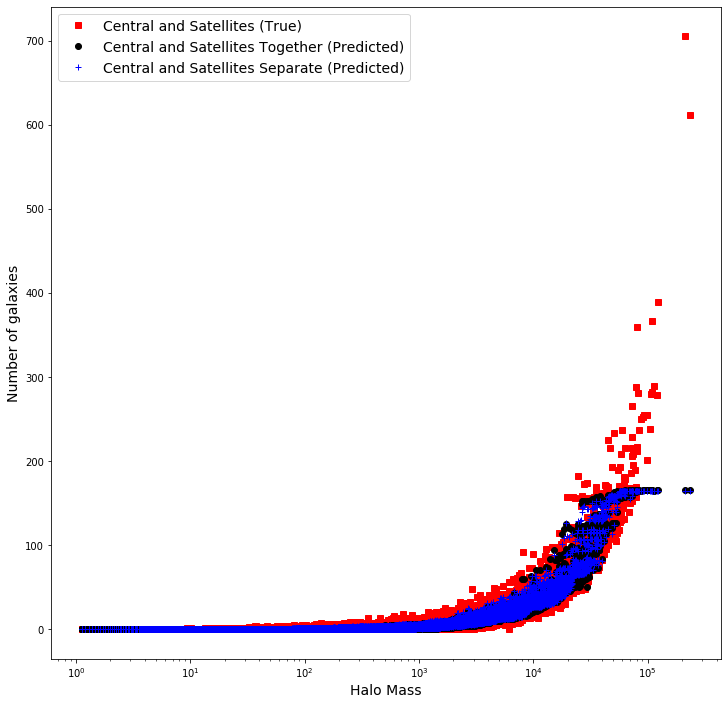

In [54]:
with PdfPages('occupation.png') as png:
    fig = plt.figure(figsize=(12,12))
    ax1 = fig.add_subplot(111)
    ax1.semilogx((df['mvir']),df['Central and Satellites (True)'],'rs',
                 label = 'Central and Satellites (True)', rasterized=True)
    ax1.semilogx((df['mvir']),df['Central and Satellites Together (Predicted)'],'ko',
                 label = 'Central and Satellites Together (Predicted)', rasterized=True)
    ax1.semilogx((df['mvir']),df['Central and Satellites Separate (Predicted)'],'b+', 
                 label = 'Central and Satellites Separate (Predicted)', rasterized=True)
    ax1.legend(fontsize=14)
    ax1.set_xlabel('Halo Mass', fontsize=14)
    ax1.set_ylabel('Number of galaxies', fontsize=14)
    png.savefig()

## Calculating number of halos in a given mass and number of satellites in a halo of given mass

In [56]:
df['log10mvir'] = np.log10(df['mvir'])
bins = np.arange(0.,5.6,0.2)
df['Mass bins'] = pd.cut(df['log10mvir'],bins = bins, right=True)
df_sort = df.sort_values(by = 'Mass bins')
df_sort = index_reset_drop(df_sort)
sat_arr = np.zeros((len(df_sort['Mass bins'].value_counts().index.values),3))
cen_arr = np.zeros_like(sat_arr)
both_t_arr = np.zeros_like(sat_arr)
both_s_arr = np.zeros_like(sat_arr)

k = 0
for i in df_sort['Mass bins'].value_counts().index.values:
    df_cut = df_sort[df_sort['Mass bins'] == i]
    df_cut = index_reset_drop(df_cut)
    sat_arr[k,0] = np.sum(df_cut['Number of Satellites (True)'])
    sat_arr[k,1] = np.sum(df_cut['Number of Satellites (Predicted)'])
    sat_arr[k] /= df_cut.shape[0]
    sat_arr[k,2] = (i.right + i.left)/2.

    cen_arr[k,0] = np.sum(df_cut['Central Occupation (True)'])
    cen_arr[k,1] = np.sum(df_cut['Central Occupation (Predicted)'])
    cen_arr[k] /= df_cut.shape[0]
    cen_arr[k,2] = sat_arr[k,2]
    
    both_t_arr[k,0] = np.sum(df_cut['Central and Satellites (True)'])
    both_t_arr[k,1] = np.sum(df_cut['Central and Satellites Together (Predicted)'])
    both_t_arr[k] /= df_cut.shape[0]
    both_t_arr[k,2] = sat_arr[k,2]

    both_s_arr[k,0] = np.sum(df_cut['Central and Satellites (True)'])
    both_s_arr[k,1] = np.sum(df_cut['Central and Satellites Separate (Predicted)'])
    both_s_arr[k] /= df_cut.shape[0]
    both_s_arr[k,2] = sat_arr[k,2]

    k += 1

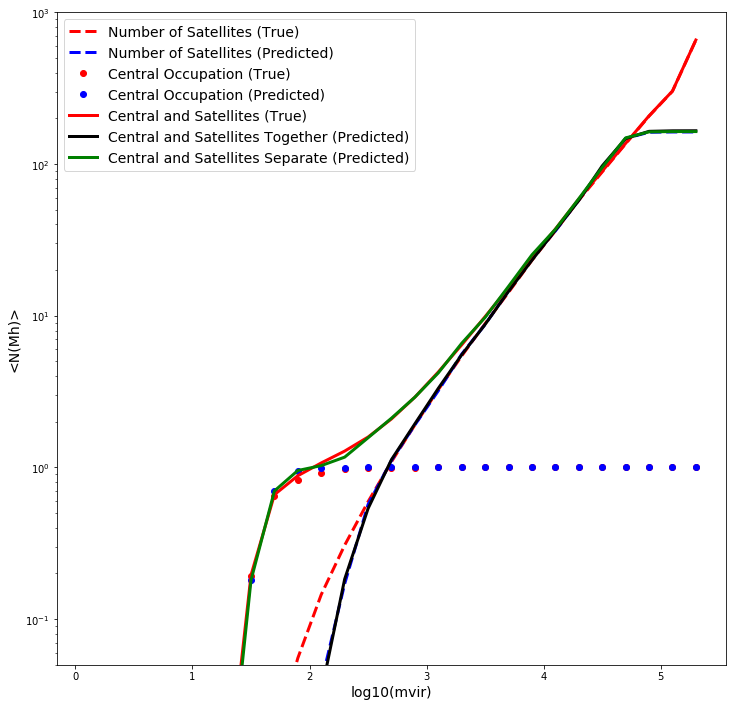

In [57]:
with PdfPages('avg_no.pdf') as pdf:
    indices = np.argsort(sat_arr[:,2])
    fig = plt.figure(figsize=(12,12))
    ax2 = fig.add_subplot(111)
    ax2.set_ylim(0.05,1000)
    ax2.semilogy(sat_arr[indices,2],sat_arr[indices,0],'r--',lw=3, label = 'Number of Satellites (True)')
    ax2.semilogy(sat_arr[indices,2],sat_arr[indices,1],'b--',lw=3, label = 'Number of Satellites (Predicted)')
    ax2.semilogy(cen_arr[indices,2],cen_arr[indices,0],'ro', label = 'Central Occupation (True)')
    ax2.semilogy(cen_arr[indices,2],cen_arr[indices,1],'bo', label = 'Central Occupation (Predicted)')
    ax2.semilogy(both_t_arr[indices,2],both_t_arr[indices,0],'r',lw=3, label = 'Central and Satellites (True)')
    ax2.semilogy(both_t_arr[indices,2],both_t_arr[indices,1],'k',lw=3, label = 'Central and Satellites Together (Predicted)')
    ax2.semilogy(both_s_arr[indices,2],both_s_arr[indices,1],'g',lw=3, label = 'Central and Satellites Separate (Predicted)')
    ax2.legend(fontsize=14)
    ax2.set_xlabel('log10(mvir)',fontsize=14)
    ax2.set_ylabel('<N(Mh)>',fontsize=14)
    pdf.savefig()

In [86]:
halo_combined_final.to_csv('full.txt', header=None, index=None, sep=',')

In [83]:
col_out = ['fofID','Number of Satellites (True)','Number of Satellites (Predicted)',
                                     'Central Occupation (True)','Central Occupation (Predicted)',
                                     'Central and Satellites (True)','Central and Satellites Separate (Predicted)']
predictions = pd.DataFrame(columns = col_out)
predictions[col_out] = halo_combined_final[col_out]
predictions.to_csv('predictions.txt', header=None, index=None, sep=',')

## Strategy

Step 1: First _classify_ which halos will have no satellites with m > 1.42.
Define class 0 as those halos that have no satellites, and class 1 as those which have 1 or more satellites.

Step 2: Next, use a _regressor_ to predict the number of satellites halos of class 1 will have.

## Step 1 Training starts here

We'll proceed in 3 steps:

Step 1: Use all halo features to train a random forest classifier. Then plot feature importances to select the top most features.

Step 2: Run the RF classifier with the most important features.

Step 3: Plot a correlation matrix of the most important features, select the least correlated features, and then run the RF classifier.

__Step 1__

In [334]:
halo_features_all =  ['phkey','con','mvir','vmax','a05','a08','vpeak',
'zvpeak','macc','smacc','mergnum','z_firstmerg','z_lastmerg',
'x','y','z','total_spin','g1_25','g2_5','g5','g10','alpha']

# Shuffling
halo_both_sample = halo_both_sample.sample(frac=1).reset_index(drop=True)

y = halo_both_sample['zero or one'].to_numpy()
X = pd.get_dummies(halo_both_sample[halo_features_all])

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 0)

rfclass_full = RandomForestClassifier(n_estimators = 300, 
                max_depth = 20.0,min_samples_leaf = 10,
                n_jobs = -1,oob_score = True,random_state = 0,
                max_features='log2')

array([[22809,   245],
       [  668,  1278]])

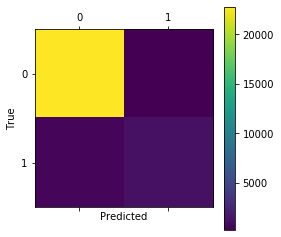

In [336]:
rfclass_full.fit(X_train, y_train);
pred_rfclass_full = rfclass_full.predict(X_val)
cm_full = confusion_matrix(y_val, pred_rfclass_full)
plt.matshow(cm_full)
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')
cm_full

In [337]:
def bar_plot(rf, clmns, outfile):
    feature_imp = rf.feature_importances_
    features_arr = np.array(clmns)

    indices = np.argsort(feature_imp)

    with PdfPages(outfile) as pdf:
        fig = plt.figure(figsize=(12,12))
        ax = fig.add_subplot(111)
        plt.subplots_adjust(left = 0.2)
        ax.barh(range(len(indices)), feature_imp[indices])
        ax.set_yticks(range(len(indices)))
        ax.set_yticklabels([features_arr[i] for i in indices])
        pdf.savefig()

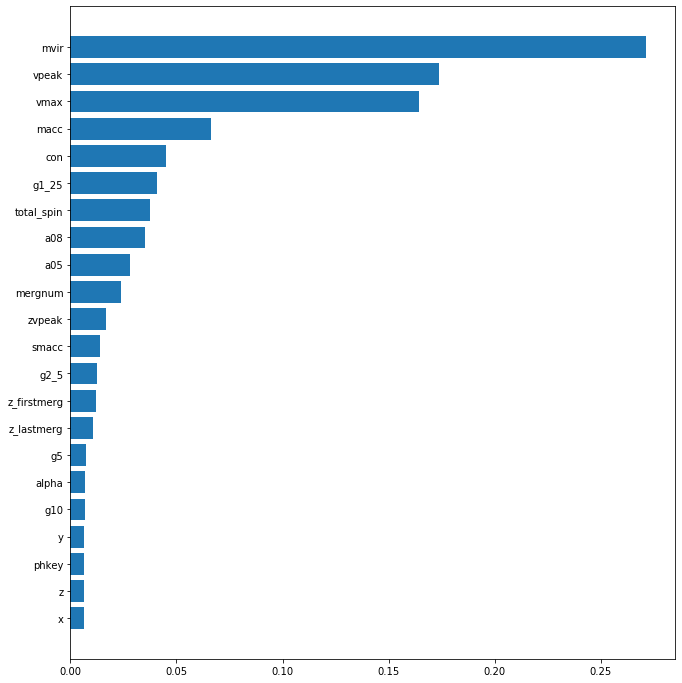

In [338]:
bar_plot(rfclass_full,X_train.columns,'feature_imp_full.pdf')

In [325]:
tn, fp, fn, tp = confusion_matrix(y_val, pred_rfclass_full).ravel()
recall = tp / (tp + fn)
prec = tp / (tp + fp)
accuracy = (tp + tn)/(tp + tn + fp + fn)
print(recall, prec, accuracy)
f1 = 2.0/((1.0/prec) + (1.0/recall))
print(f1)

0.6684607104413348 0.8263473053892215 0.96492
0.7390657542398096


In [326]:
rfclass_full_scores = cross_val_score(rfclass_full, X, y, scoring="f1", cv=5)
print(rfclass_full_scores)
print(np.mean(rfclass_full_scores),np.std(rfclass_full_scores))

[0.73942898 0.73798338 0.74018018 0.73282443 0.74047448]
0.7381782892819928 0.0028123342415645354


__Step 2__

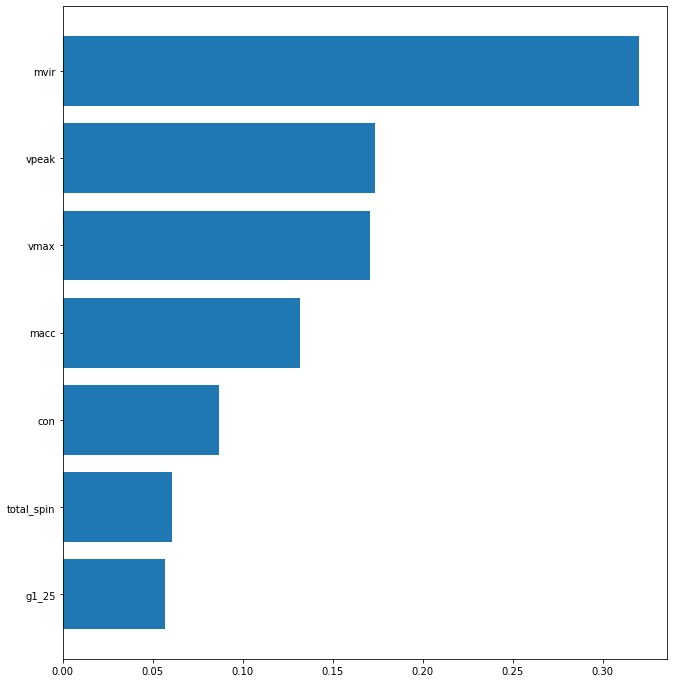

In [339]:
# Using top 7 features
feature_imp = rfclass_full.feature_importances_
features_arr = np.array(X_train.columns)

indices = np.argsort(feature_imp)

feature_pos = np.hstack((indices[-7:-1],indices[-1]))
halo_features_top = features_arr[feature_pos]

X = pd.get_dummies(halo_both_sample[halo_features_top])

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 0)
rfclass_top = RandomForestClassifier(n_estimators = 100, 
                max_depth = 20.0,min_samples_leaf = 5,
                n_jobs = -1,oob_score = True,random_state = 0,
                max_features='log2')
rfclass_top.fit(X_train, y_train);
pred_rfclass_top = rfclass_top.predict(X_val)

bar_plot(rfclass_top, X_train.columns, 'feature_imp_top.pdf')

In [340]:
rfclass_top_scores = cross_val_score(rfclass_top, X, y, scoring="f1", cv=5)
print(rfclass_top_scores)
print(np.mean(rfclass_top_scores),np.std(rfclass_top_scores))

[0.73068592 0.72557471 0.7280364  0.72513369 0.72760116]
0.7274063761900645 0.0019854660652186733


In [329]:
def corr_mat(correlation,outfile):
    with PdfPages(outfile) as pdf:
        f, ax_hm = plt.subplots(figsize=(7, 7))
        ax_hm = sns.heatmap(correlation, 
        xticklabels=correlation.columns,
        yticklabels=correlation.columns, annot = True, square = True)
        ax_hm.set_ylim(len(correlation), -0.01)
        pdf.savefig()    

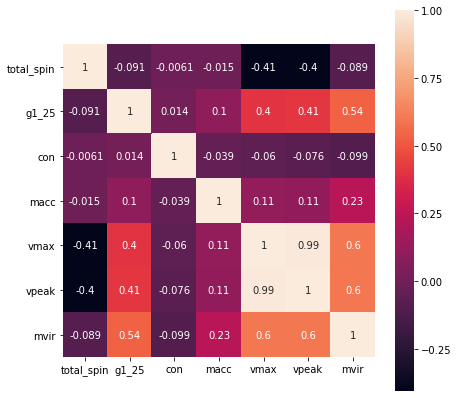

In [341]:
corr_mat(X.corr(),'heatmap_sat_class_red.pdf')

__Step 3__

In [344]:
# Using only uncorrelated features
feature_uncorr_class = ['mvir','vpeak','macc','con',
                        'a08','total_spin']

X = pd.get_dummies(halo_both_sample[feature_uncorr_class])

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 0)
rfclass_uncorr = RandomForestClassifier(n_estimators = 100, 
                max_depth = 20.0,min_samples_leaf = 5,
                n_jobs = -1,oob_score = True,random_state = 0,
                max_features='log2')
rfclass_uncorr.fit(X_train, y_train);
pred_rf_uncorr = rfclass_uncorr.predict(X_val)

In [345]:
rfclass_uncorr_scores = cross_val_score(rfclass_uncorr, X, y, scoring="f1", cv=5)
print(rfclass_uncorr_scores)
print(np.mean(rfclass_uncorr_scores),np.std(rfclass_uncorr_scores))

[0.74050179 0.73837416 0.73680556 0.73236441 0.73706897]
0.737022975975153 0.002671309689009511


## Predictions for Step 1

Now making predictions on the entire halo data (~ 1.8 million)

In [346]:
X_full = pd.get_dummies(halo_full[feature_uncorr_class])
pred_full = rfclass_uncorr.predict(X_full)

In [347]:
y_full = halo_full['zero or one']
tn, fp, fn, tp = confusion_matrix(y_full, pred_full).ravel()
recall = tp / (tp + fn)
prec = tp / (tp + fp)
accuracy = (tp + tn)/(tp + tn + fp + fn)
print(recall, prec, accuracy)
f1 = 2.0/((1.0/prec) + (1.0/recall))
print(f1)

0.669763835037011 0.8281555090655509 0.9636365225724218
0.7405854152862766


## Step 2

Now run a regressor to predict number of satellites a halo of class 1 from above will have

In [348]:
# sat_num.to_numpy() gives the values of the 2nd column (# of sats)
# in sat_num

sat_num = sat_data_above['fofID'].value_counts()
sat_num_np = sat_num.to_numpy()

# ground_truth_above contains 2 columns: haloIDs and # of sats

ground_truth_above = pd.DataFrame({'fofID': haloID_above, 
                    'Number of Sats': sat_num_np})

We now have a pd df, _ground_truth_above_, which contains haloIDs and # of sats, arranged in descending order of # of sats. We then need to first pick _haloID_above_ from the central data, and then assign _sat_num_np_ to the halos selected. This is done in two steps:

1) We sort _ground_truth_above_ by fofID.

2) We sort _halo_above_ by fofID. 

In [349]:
ground_truth_above_sort = ground_truth_above.sort_values(by = ['fofID'])
ground_truth_above_sort = index_reset_drop(ground_truth_above_sort)

halo_above_sort = halo_above.sort_values(by = ['fofID'])
halo_above_sort = index_reset_drop(halo_above_sort)

halo_above_sort['Number of Sats'] = ground_truth_above_sort['Number of Sats']

# Shuffle
halo_above_sort = halo_above_sort.sample(frac=1,random_state=0).reset_index(drop=True)

## Step 2 training starts here

In [350]:
y = halo_above_sort['Number of Sats'].to_numpy()
X = pd.get_dummies(halo_above_sort[halo_features_all])
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 0)

In [351]:
rfreg_all = RandomForestRegressor(n_estimators = 100, 
                max_depth = 20.0,min_samples_leaf = 5,
                n_jobs = -1,oob_score = True,random_state = 0,
                max_features='log2')
rfreg_all.fit(X_train, y_train);
pred_rfreg_all = rfreg_all.predict(X_val)

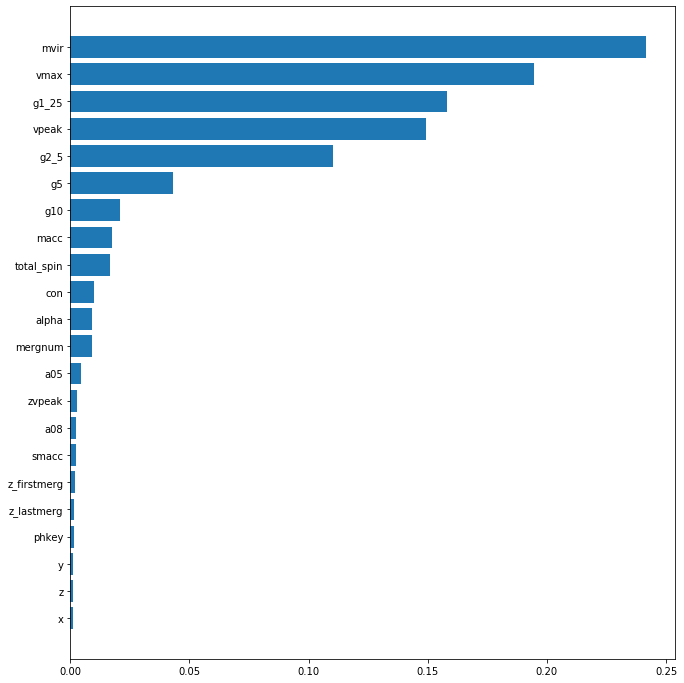

In [352]:
bar_plot(rfreg_all,X_train.columns,'feature_imp_sat_reg_full.pdf')

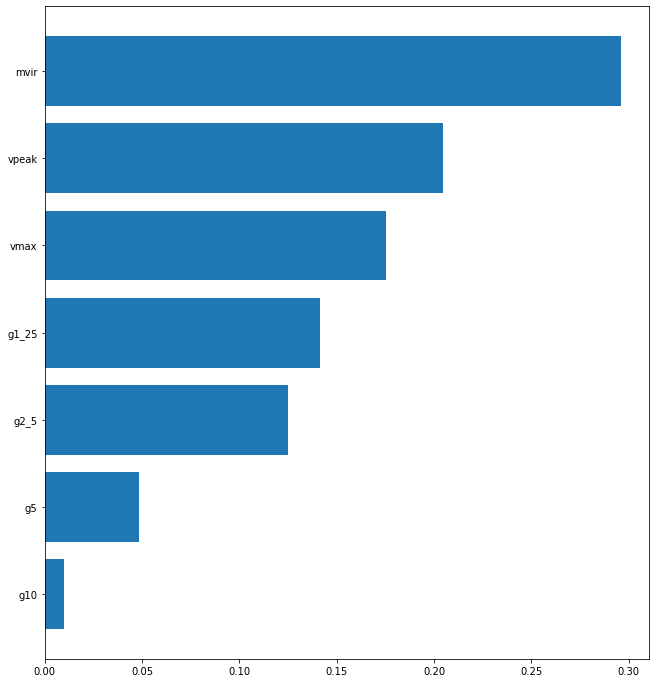

In [353]:
feature_imp = rfreg_all.feature_importances_
features_arr = np.array(X_train.columns)
indices = np.argsort(feature_imp)

feature_pos = np.hstack((indices[-7:-1],indices[-1]))
halo_features_top = features_arr[feature_pos]

X = pd.get_dummies(halo_above_sort[halo_features_top])

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 0)
rfreg_top = RandomForestRegressor(n_estimators = 100, 
                max_depth = 20.0,min_samples_leaf = 5,
                n_jobs = -1,oob_score = True,random_state = 0,
                max_features='log2')
rfreg_top.fit(X_train, y_train);
pred_rfreg_top = rfreg_top.predict(X_val)

bar_plot(rfreg_top,X_train.columns,'feature_imp_sat_reg_top.pdf')

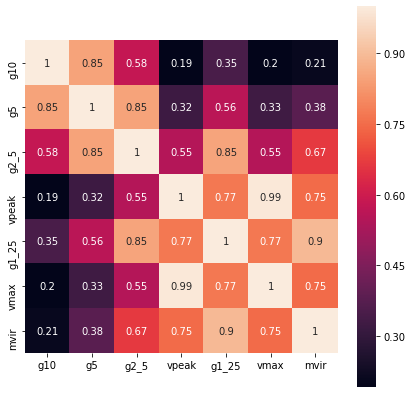

In [354]:
corr_mat(X.corr(),'heatmap_sat_reg_red.pdf')

In [355]:
feature_uncorr_reg = ['mvir','vpeak','g2_5','g5','g10']

X = pd.get_dummies(halo_above_sort[feature_uncorr_reg])

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 0)
rfreg_uncorr = RandomForestRegressor(n_estimators = 100, 
                max_depth = 20.0,min_samples_leaf = 5,
                n_jobs = -1,oob_score = True,random_state = 0,
                max_features='log2')
rfreg_uncorr.fit(X_train, y_train);
pred_rf_uncorr = rfreg_uncorr.predict(X_val)

In [356]:
rfreg_uncorr_scores = cross_val_score(rfreg_uncorr, X, y, scoring="r2", cv=5)
print(rfreg_uncorr_scores)
print(np.mean(rfreg_uncorr_scores),np.std(rfreg_uncorr_scores))

[0.93452103 0.93173127 0.93375153 0.89924122 0.91663508]
0.9231760261160918 0.013633793118745262


In [357]:
poly_features = PolynomialFeatures(degree=2, include_bias=True)
X_scale = X.copy()
X_scale[feature_uncorr_reg] = scaler.fit_transform(X_scale[feature_uncorr_reg])
X_poly = poly_features.fit_transform(X_scale)
X_train_poly, X_val_poly, y_train, y_val = train_test_split(X_poly, y, random_state = 0)

ridge_reg = Ridge(alpha=0.01, solver="svd", random_state=0)
ridgereg_scores = cross_val_score(ridge_reg, X_poly, y,
                                scoring="r2", cv=5)
print(ridgereg_scores)
print(np.mean(ridgereg_scores),np.std(ridgereg_scores))

[0.92900913 0.92525613 0.92946349 0.94138205 0.93848777]
0.9327197138460159 0.006138126546016571


In [358]:
print(np.mean(rfreg_uncorr_scores),np.std(rfreg_uncorr_scores))

0.9231760261160918 0.013633793118745262


## Predictions for Step 2

In [359]:
ridge_reg.fit(X_train_poly,y_train)
pred_ridge_reg = ridge_reg.predict(X_poly)
r2_score(pred_ridge_reg,y)

0.9320460487268594

## Setting up predictions for a new data set 

This data set only contains halo properties for which we must predict number of halos   

In [360]:
X_full_cp = cent_data.copy()
X_full = pd.get_dummies(cent_data[feature_uncorr_class])
pred_full = rfclass_uncorr.predict(X_full)
    
X_full_cp['Predicted number of satellites'] = pred_full
X_more = X_full_cp.loc[X_full_cp['Predicted number of satellites'] == 1]
X_none = X_full_cp.loc[X_full_cp['Predicted number of satellites'] == 0]

In [361]:
X_more_reg = pd.get_dummies(X_more[feature_uncorr_reg])
pred_rf_full = rfreg_uncorr.predict(X_more_reg)

In [362]:
X_more_cp = X_more.copy()
X_more_cp['Predicted number of satellites'] = pred_rf_full
X_more = X_more_cp.copy()

X_none_cp = X_none.copy()
X_none_cp['Predicted number of satellites'] = 0
X_none = X_none_cp.copy()

In [363]:
X_full_new = X_none.append(X_more)

In [364]:
X_full_sort = X_full_new.sort_values(by = 'fofID')
X_full_sort = index_reset_drop(X_full_sort)

## Testing regression model on entire satellite data

In [380]:
halo_above_sample2 = halo_above_sort.sample(n=more_num,random_state=0).reset_index(drop=True)
halo_above_sample2 = index_reset_drop(halo_above_sample2)
halo_below_sample2 = halo_below.sample(n=zero_num,random_state=0)
halo_below_sample2 = index_reset_drop(halo_below_sample2)
halo_below_sample2['Number of Sats'] = 0
halo_sample2 = halo_above_sample2.append(halo_below_sample2, ignore_index = True)

halo_sample2 = halo_sample2.sample(frac=1).reset_index(drop=True)
halo_sample2 = index_reset_drop(halo_sample2)

In [383]:
y = halo_sample2['Number of Sats'].to_numpy()
X = pd.get_dummies(halo_sample2[halo_features_all])
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 0)

rfreg_2 = RandomForestRegressor(n_estimators = 100, 
                max_depth = 20.0,min_samples_leaf = 5,
                n_jobs = -1,oob_score = True,random_state = 0,
                max_features='log2')
rfreg_2.fit(X_train, y_train);
pred_rfreg_all = rfreg_2.predict(X_val)

In [387]:
rfreg_uncorr_scores_2 = cross_val_score(rfreg_2, X, y, scoring="r2", cv=5)
print(rfreg_uncorr_scores_2)
print(np.mean(rfreg_uncorr_scores_2),np.std(rfreg_uncorr_scores_2))

[0.89881273 0.90141296 0.88945142 0.91353624 0.87460223]
0.8955631129385745 0.012996348539601858


In [388]:
X_above = pd.get_dummies(halo_above_sample2[halo_features_all])
pred_rfreg2_above = rfreg_2.predict(X_above)

In [418]:
haloID_sample2 = halo_sample2['fofID'].unique()
sample2_sort = X_full_sort[X_full_sort['fofID'].isin(haloID_sample2)]
sample2_sort = index_reset_drop(sample2_sort)

In [412]:
halo_sample2_sort = halo_sample2.sort_values(by = 'fofID')
halo_sample2_sort = index_reset_drop(halo_sample2_sort)
X_sample2_sort = pd.get_dummies(halo_sample2_sort[halo_features_all])
pred_rfreg2 = rfreg_2.predict(X_sample2_sort)
pred_rfreg2 = np.rint(pred_rfreg2)

In [428]:
r2_score(pred_rfreg2,halo_sample2_sort['Number of Sats'])

0.9041455162085756

In [436]:
r2_score(sample2_sort['Predicted number of satellites'],
         halo_sample2_sort['Number of Sats'])

0.9085206712998282

## Testing the original Central data set

In [386]:
X_full_sort_above = X_full_sort[X_full_sort['fofID'].isin(haloID_above)]
y_above_true = ground_truth_above_sort['Number of Sats']
y_above_pred = X_full_sort_above['Predicted number of satellites']

r2_score(y_above_pred,y_above_true)

0.9387642587611655

In [271]:
X_full_sort_below = X_full_sort[X_full_sort['fofID'].isin(haloID_below)]
y_below_true = halo_below['zero or one']
y_below_pred = X_full_sort_below['Predicted number of satellites']
y_below_pred = index_reset_drop(y_below_pred)
zero_pred = y_below_pred[y_below_pred['Predicted number of satellites'] == 0.]

#print(zero_pred.shape[0]/y_below_true.shape[0])

0.9881765090141977


array([[22666,   207],
       [  152,  1975]])

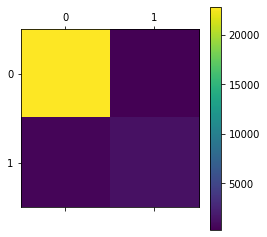

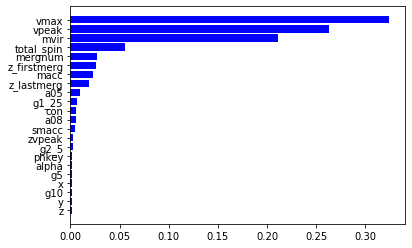

In [47]:
with PdfPages('feature_imp_full.pdf') as export_pdf:
    feature_imp = rfclass_full.feature_importances_
    features_arr = np.array(X_train.columns)

    indices = np.argsort(feature_imp)
    plt.barh(range(len(indices)), feature_imp[indices], color='b', align='center');
    plt.yticks(range(len(indices)), [features_arr[i] for i in indices]);
    export_pdf.savefig()

0.9285378467324871 0.9051329055912007 0.98564
0.9166860060338826


[0.919233   0.91980454 0.92094634 0.91973341 0.91935484]
0.9198144261502879 0.0006061605414067378


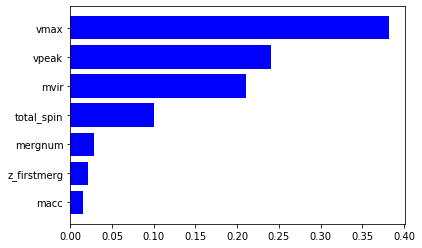

[0.9170076  0.91467969 0.9136939  0.91736735 0.91810842]
0.9161713922740781 0.0016878848665957018


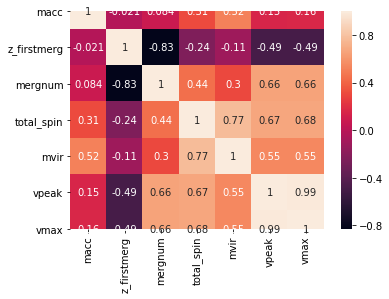

[0.90988626 0.91123919 0.90903857 0.91451753 0.90993072]
0.910922455327456 0.001930344397451475


## Predictions for Central occupancy

In [55]:
X_full = pd.get_dummies(cent_data[feature_uncorr_class])
pred_full = rfclass_uncorr.predict(X_full)

In [56]:
y_full = cent_data_cp['stellarMass']
tn, fp, fn, tp = confusion_matrix(y_full, pred_full).ravel()
recall = tp / (tp + fn)
prec = tp / (tp + fp)
accuracy = (tp + tn)/(tp + tn + fp + fn)
print(recall, prec, accuracy)
f1 = 2.0/((1.0/prec) + (1.0/recall))
print(f1)

0.9229846339663155 0.8921708268148598 0.9839730121730831
0.9073161851037839


In [57]:
cent_data_cp['Predicted Central Occupancy'] = pred_full
cent_data_cp_sort = cent_data_cp.sort_values(by = 'fofID')
cent_data_cp_sort = cent_data_cp_sort.reset_index()
cent_data_cp_sort = cent_data_cp_sort.drop(columns = ['index'])

cent_data_cp_sort['Predicted number of satellites'] = X_full_sort['Predicted number of satellites']


In [58]:
cent_data_sort = cent_data.sort_values(by = 'fofID')
cent_data_sort = cent_data_sort.reset_index()
cent_data_sort = cent_data_sort.drop(columns = ['index'])

cent_data_sort['Predicted number of satellites'] = cent_data_cp_sort['Predicted number of satellites']
cent_data_sort['Predicted Central Occupancy'] = cent_data_cp_sort['Predicted Central Occupancy'] 

## Binning

0.06887649282632247
[[2854    0    0    0]
 [ 102    0    0    0]
 [  11    0    0    0]
 [   1    0    0    0]]


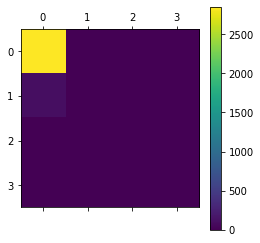

In [295]:
halo_bin_features =  ['phkey','con','mvir','vmax','a05','a08','vpeak',
'zvpeak','macc','smacc','mergnum','z_firstmerg','z_lastmerg',
'x','y','z','type','total_spin','g1_25','g2_5','g5','g10','alpha']
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

#halo_bin_features = ['mvir','vpeak','g2_5','g5']

N = 6
features_arr = np.array(halo_bin_features)
feature_imp = np.zeros((N,features_arr.shape[0]))
indices = np.zeros((N,features_arr.shape[0]))

for j in range(1,2):
    halo_data_bin = halo_cen_unq_sort[(halo_cen_unq_sort['centralMvir'] < 10.**(j+1)) &
                (halo_cen_unq_sort['centralMvir'] > 10.**(j))]
    halo_data_bin = halo_data_bin.reset_index()
    halo_data_bin = halo_data_bin.drop(columns = ['index'])
    halo_ID_bin = halo_data_bin['fofID']

    ground_truth_bin = ground_truth_sort[ground_truth_sort['fofID'].isin(halo_ID_bin)]
    ground_truth_bin = ground_truth_bin.reset_index()
    ground_truth_bin = ground_truth_bin.drop(columns = ['index']) 
                                       
    y_bin = ground_truth_bin['Number of Sats'].to_numpy()
    X_bin = pd.get_dummies(halo_data_bin[halo_bin_features])
                                       
    X_bin_train, X_bin_val, y_bin_train, y_bin_val = train_test_split(X_bin, y_bin, random_state = 0)
#    y_bin_val_arr = np.zeros((N,y_bin_train.shape[0])) 
#    pred_rf_arr = np.zeros_like(y_bin_val)
#    X_bin_val_arr = np.zeros_like(y_bin_val)
#    y_bin_val_arr[j,:] = y_bin_val
#    pred_rf_arr[j,:] = pred_rf
#    X_bin_val_arr[j,:] = X_bin_val
    rfreg_bin = RandomForestRegressor(n_estimators = 100, 
                max_depth = 5.0,min_samples_leaf = 3,
                n_jobs = -1,oob_score = True,random_state = 0,
                max_features='log2')

    rfclass_bin = RandomForestClassifier(n_estimators = 100, 
                max_depth = 5.0,min_samples_leaf = 3,
                n_jobs = -1,oob_score = True,random_state = 0,
                max_features='log2')

    rfreg_bin.fit(X_bin_train, y_bin_train);
    pred_rf = rfreg_bin.predict(X_bin_val)
    print(r2_score(y_bin_val,pred_rf))

    rfclass_bin.fit(X_bin_train, y_bin_train);
    pred_rf = rfclass_bin.predict(X_bin_val)
    cm = confusion_matrix(y_bin_val, pred_rf)
    plt.matshow(cm)
    plt.colorbar()

    print(cm)    
    feature_imp[j,:] = rfreg_bin.feature_importances_

    indices[j,:] = np.argsort(feature_imp[j,:])                     


In [258]:
import collections, numpy

print(collections.Counter(pred_rf), 
      collections.Counter(y_bin_val))

Counter({1: 2968}) Counter({1: 2854, 2: 102, 3: 11, 4: 1})


In [326]:
X_bin_cp = X_bin.copy()
X_bin_cp['num_sat'] = y_bin
X_bin_cp.tail()

,phkey,con,mvir,vmax,a05,a08,vpeak,zvpeak,macc,smacc,...,y,z,type,total_spin,g1_25,g2_5,g5,g10,alpha,num_sat
11865,16762807,0.949853,97.684540,153.26578,0.643761,0.876447,195.39769,0.089288,-261.507308,-2.677059,...,16.663414,472.22916,0,3.392575,8.227546,3.350343,1.166894,0.908859,0.650985,1
11866,16758939,1.116512,49.487762,143.61821,0.463865,0.491220,153.46486,0.623590,-36.412346,-0.735785,...,42.278080,473.09120,0,1.970662,3.749091,3.793927,2.711788,1.705927,0.275349,1
11867,16771808,1.157878,77.459110,172.92862,0.331289,0.764481,203.03825,0.019933,-26.481538,-0.341878,...,25.969719,448.89710,0,3.263480,5.900879,4.619894,2.528303,1.177535,0.384606,1
11868,16752035,1.187418,77.975494,177.73372,0.415625,0.719962,178.04948,0.019933,-46.343308,-0.594332,...,57.536346,441.98224,0,4.586824,2.201721,1.470524,1.160839,1.031394,0.825774,1
11869,16754841,1.031447,55.082030,137.49818,0.519315,0.790902,148.65695,0.242469,-16.551154,-0.300482,...,40.149050,462.37775,0,2.181708,2.124331,2.115950,2.133400,1.283053,0.416986,1


In [327]:
outlier = X_bin_cp.loc[X_bin_cp['num_sat'] != 1]
outlier = outlier.reset_index()
outlier = outlier.drop(columns = ['index'])
outlier['con_new'] = outlier.con

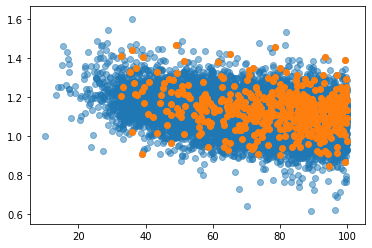

In [328]:
plt.scatter(X_bin.mvir,X_bin.con,alpha=0.5)
plt.scatter(outlier.mvir,outlier.con_new)

In [321]:
X_bin_cp.loc[X_bin_cp['num_sat'] != 1, 'con']= 1.1*(X_bin_cp.con)



In [305]:
X_bin_cp

,phkey,con,mvir,vmax,a05,a08,vpeak,zvpeak,macc,smacc,...,y,z,type,total_spin,g1_25,g2_5,g5,g10,alpha,num_sat
0,5767,1.112402,96.823880,178.96555,0.431211,0.569789,192.94147,1.077875,-92.686154,-0.957265,...,21.525980,37.102856,0,1.291159,4.077098,2.535460,1.190493,0.951082,0.803949,1
1,24109,1.078663,70.832050,156.36598,0.378137,0.778536,167.37381,1.630271,76.135000,1.074867,...,57.445385,40.581707,0,1.796679,14.375061,3.298037,1.633542,1.346350,0.580303,1
2,14246,1.176147,73.844345,172.88109,0.379887,0.562842,181.43068,0.687109,62.894038,0.851711,...,9.290336,24.249660,0,1.948388,2.042845,1.168416,0.927144,0.989585,0.887937,1
3,7080,1.164101,92.262400,184.29446,0.379969,0.649457,208.81897,1.385718,-19.861154,-0.215268,...,22.811821,60.532032,0,0.362541,4.362735,4.172705,1.897275,1.046074,0.320896,1
4,3266,1.263387,80.815670,191.37340,0.406701,0.452867,219.74792,1.173417,62.894231,0.778243,...,22.676504,18.497011,0,0.240367,6.916746,4.510846,2.999653,1.838928,0.301295,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11865,16762807,0.949853,97.684540,153.26578,0.643761,0.876447,195.39769,0.089288,-261.507308,-2.677059,...,16.663414,472.229160,0,3.392575,8.227546,3.350343,1.166894,0.908859,0.650985,1
11866,16758939,1.116512,49.487762,143.61821,0.463865,0.491220,153.46486,0.623590,-36.412346,-0.735785,...,42.278080,473.091200,0,1.970662,3.749091,3.793927,2.711788,1.705927,0.275349,1
11867,16771808,1.157878,77.459110,172.92862,0.331289,0.764481,203.03825,0.019933,-26.481538,-0.341878,...,25.969719,448.897100,0,3.263480,5.900879,4.619894,2.528303,1.177535,0.384606,1
11868,16752035,1.187418,77.975494,177.73372,0.415625,0.719962,178.04948,0.019933,-46.343308,-0.594332,...,57.536346,441.982240,0,4.586824,2.201721,1.470524,1.160839,1.031394,0.825774,1


0.20288540173745706
[[2854    0    0    0]
 [ 102    0    0    0]
 [  11    0    0    0]
 [   1    0    0    0]]


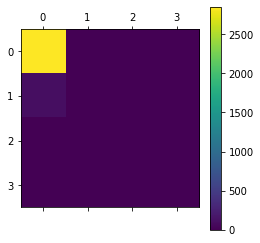

In [322]:
halo_bin_features =  ['phkey','con','mvir','vmax','a05','a08','vpeak',
'zvpeak','macc','smacc','mergnum','z_firstmerg','z_lastmerg',
'x','y','z','type','total_spin','g1_25','g2_5','g5','g10','alpha']

#halo_bin_features = ['mvir','vpeak','g2_5','g5']

N = 6
features_arr = np.array(halo_bin_features)
feature_imp = np.zeros((N,features_arr.shape[0]))
indices = np.zeros((N,features_arr.shape[0]))

for j in range(1,2):                                       
    X_bin_cp1 = pd.get_dummies(X_bin_cp[halo_bin_features])
    X_bin_train, X_bin_val, y_bin_train, y_bin_val = train_test_split(X_bin_cp1, y_bin, random_state = 0)
    rfreg_bin = RandomForestRegressor(n_estimators = 100, 
                max_depth = 5.0,min_samples_leaf = 3,
                n_jobs = -1,oob_score = True,random_state = 0,
                max_features='log2')

    rfclass_bin = RandomForestClassifier(n_estimators = 100, 
                max_depth = 5.0,min_samples_leaf = 3,
                n_jobs = -1,oob_score = True,random_state = 0,
                max_features='log2')

    rfreg_bin.fit(X_bin_train, y_bin_train);
    pred_rf = rfreg_bin.predict(X_bin_val)
    print(r2_score(y_bin_val,pred_rf))

    rfclass_bin.fit(X_bin_train, y_bin_train);
    pred_rf = rfclass_bin.predict(X_bin_val)
    cm = confusion_matrix(y_bin_val, pred_rf)
    plt.matshow(cm)
    plt.colorbar()

    print(cm)    

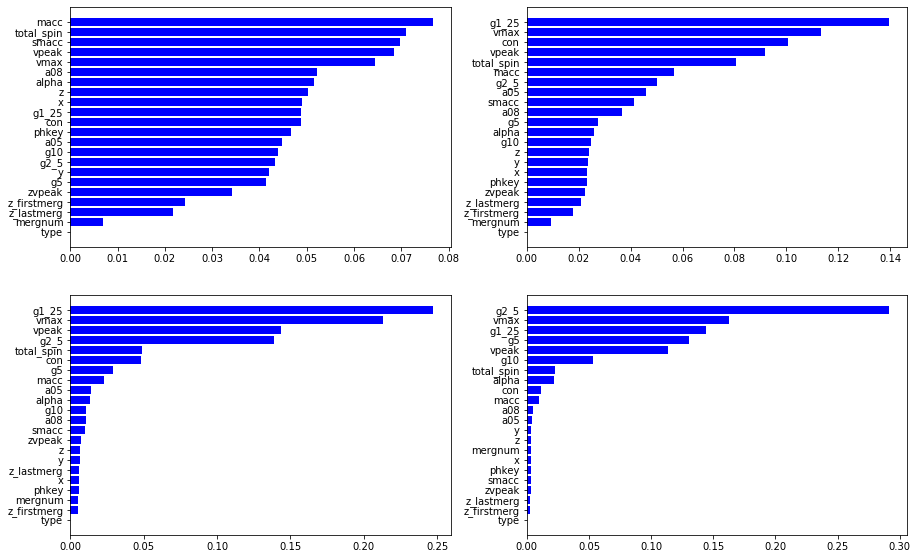